### train/test data 로드 및 전처리

In [8]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

In [9]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train['습도(%)'] = train['습도(%)'].interpolate()
train['풍속(m/s)'] = train['풍속(m/s)'].interpolate()
train['강수량(mm)'] = train['강수량(mm)'].fillna(0)
train['일시'] = pd.to_datetime(train['일시'])

train_df = train.drop(['num_date_time', '일조(hr)','일사(MJ/m2)'], axis=1)
train_df

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh)
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40
...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,881.04
203996,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,798.96
203997,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,825.12
203998,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,640.08


In [10]:
from sklearn.preprocessing import LabelEncoder

build = pd.read_csv('data/building_info.csv')
build['냉방 비율'] = build['냉방면적(m2)']/build['연면적(m2)']
build['태양광용량(kW)'] = build['태양광용량(kW)'].replace("-",0)
build['ESS저장용량(kWh)'] = build['ESS저장용량(kWh)'].replace("-",0)
build['PCS용량(kW)'] = build['PCS용량(kW)'].replace("-",0)

build = build.astype({'태양광용량(kW)':float, 'ESS저장용량(kWh)':float,'PCS용량(kW)':float})

le = LabelEncoder()
le.fit(build['건물유형'])
build['건물유형'] = le.transform(build['건물유형'])
build = build.drop(['연면적(m2)','냉방면적(m2)','건물유형','PCS용량(kW)'], axis=1) # 다중공선성 문제 예방을 위해 column 일부 삭제
build

,건물번호,태양광용량(kW),ESS저장용량(kWh),냉방 비율
0,1,0.0,0.0,0.357666
1,2,0.0,0.0,0.809925
2,3,40.0,0.0,0.665429
3,4,60.0,0.0,0.463171
4,5,0.0,2557.0,0.728566
...,...,...,...,...
95,96,0.0,0.0,0.648349
96,97,0.0,0.0,0.469311
97,98,0.0,0.0,0.324266
98,99,0.0,0.0,0.759566


In [11]:
train_df = pd.merge(train_df, build, on = '건물번호')
cols = list(train_df)
cols.insert(len(cols), cols.pop(cols.index('전력소비량(kWh)')))
train_df = train_df.reindex(columns = cols)
train_df

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),태양광용량(kW),ESS저장용량(kWh),냉방 비율,전력소비량(kWh)
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.0,0.357666,1085.28
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.0,0.357666,1047.36
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.0,0.357666,974.88
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.0,0.357666,953.76
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.0,0.357666,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,0.0,0.0,0.696291,881.04
203996,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,0.0,0.0,0.696291,798.96
203997,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,0.0,0.0,0.696291,825.12
203998,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,0.0,0.0,0.696291,640.08


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   건물번호          204000 non-null  int64         
 1   일시            204000 non-null  datetime64[ns]
 2   기온(C)         204000 non-null  float64       
 3   강수량(mm)       204000 non-null  float64       
 4   풍속(m/s)       204000 non-null  float64       
 5   습도(%)         204000 non-null  float64       
 6   태양광용량(kW)     204000 non-null  float64       
 7   ESS저장용량(kWh)  204000 non-null  float64       
 8   냉방 비율         204000 non-null  float64       
 9   전력소비량(kWh)    204000 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 15.6 MB


### test data

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [14]:
test_df = test.drop(['num_date_time'], axis=1)
test_df = pd.merge(test_df, build, on = '건물번호')
test_df['일시'] = pd.to_datetime(test_df['일시'])
test_df

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),태양광용량(kW),ESS저장용량(kWh),냉방 비율
0,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,0.0,0.0,0.357666
1,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,0.0,0.0,0.357666
2,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,0.0,0.0,0.357666
3,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,0.0,0.0,0.357666
4,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,0.0,0.0,0.357666
...,...,...,...,...,...,...,...,...,...
16795,100,2022-08-31 19:00:00,22.5,0.0,0.9,84,0.0,0.0,0.696291
16796,100,2022-08-31 20:00:00,20.7,0.0,0.4,95,0.0,0.0,0.696291
16797,100,2022-08-31 21:00:00,20.2,0.0,0.4,98,0.0,0.0,0.696291
16798,100,2022-08-31 22:00:00,20.1,0.0,1.1,97,0.0,0.0,0.696291


### 3차원 데이터프레임 변환

In [15]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d['일시'].value_counts())
    sample_size = len(df_2d.건물번호.value_counts())
    return df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])

In [16]:
train_x_array = df2d_to_array3d(train_df)
test_x_array = df2d_to_array3d(test_df)

In [17]:
print(train_x_array.shape) # 건물 수, 시간 단계 수,특징 수
print(test_x_array.shape)

(100, 2040, 8)
(100, 168, 7)


### 시게열 test 함수 제작


ADF Test Results:
ADF Statistic: -3.891436846726445
p-value: 0.002098778859224151
Critical Values: {'1%': -3.4336010696328323, '5%': -2.8629761530066187, '10%': -2.567534545549574}
Is data stationary?: Yes


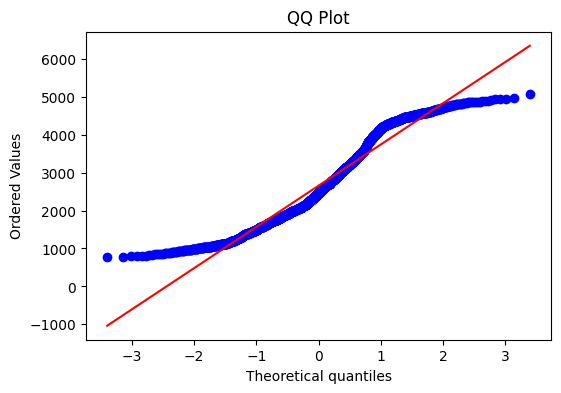


Homoscedasticity Test Results:
Bartlett Test p-value: 0.058713782247809036
Levene Test p-value: 0.7131960256937061
Equal variance? Yes


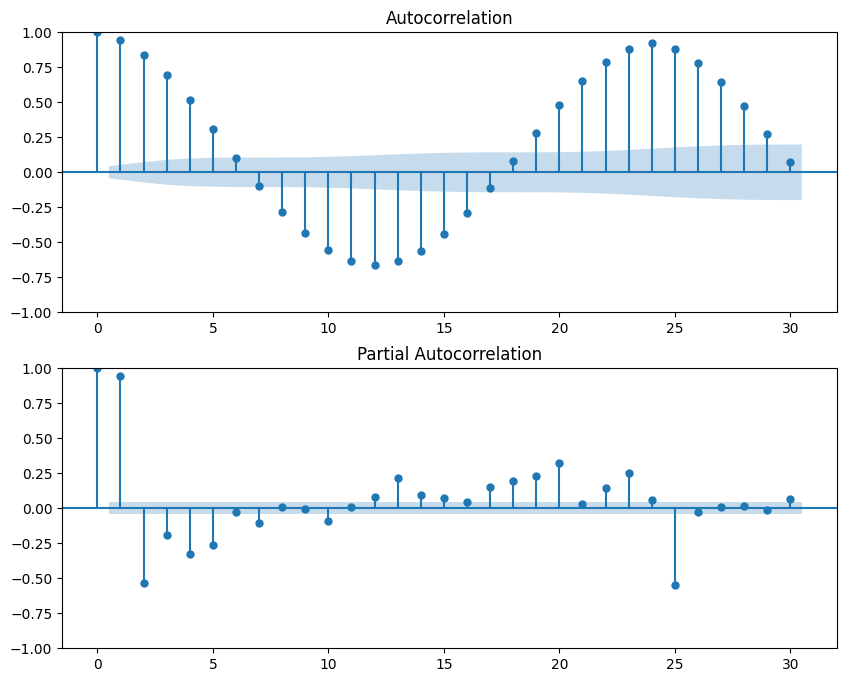

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import probplot, bartlett, levene
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class TimeSeriesTester:
    def __init__(self, data):
        self.data = data

    def plot_qq_plot(self):
        plt.figure(figsize=(6, 4))
        probplot(self.data, dist='norm', plot=plt)
        plt.title("QQ Plot")
        plt.show()

    def plot_acf_pacf(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        plot_acf(self.data, ax=ax1, lags=30)
        plot_pacf(self.data, ax=ax2, lags=30)
        plt.show()

    def test_stationarity(self):
        adf_result = adfuller(self.data)
        adf_test_results = {
            "ADF Statistic": adf_result[0],
            "p-value": adf_result[1],
            "Critical Values": adf_result[4],
            "Is data stationary?": "Yes" if adf_result[1] <= 0.05 else "No"
        }
        print("\nADF Test Results:")
        for key, value in adf_test_results.items():
            print(f"{key}: {value}")

    def test_homoscedasticity(self):
        n = len(self.data)
        group1 = self.data[:n // 2]
        group2 = self.data[n // 2:]

        bartlett_result = bartlett(group1, group2)
        levene_result = levene(group1, group2)

        equal_variance = bartlett_result.pvalue > 0.05 and levene_result.pvalue > 0.05
        print("\nHomoscedasticity Test Results:")
        print("Bartlett Test p-value:", bartlett_result.pvalue)
        print("Levene Test p-value:", levene_result.pvalue)
        print("Equal variance?", "Yes" if equal_variance else "No")

# 클래스 인스턴스 생성
data = train_x_array[0, :,7] # 첫 번째 건물 전기 사용량, 1차 차분 사용
ts_tester = TimeSeriesTester(data)

# 클래스의 메서드 호출하여 시계열 데이터에 대한 검정 수행
ts_tester.test_stationarity()
ts_tester.plot_qq_plot()
ts_tester.test_homoscedasticity()
ts_tester.plot_acf_pacf()


### 1차 차분


ADF Test Results:
ADF Statistic: -11.475583230722672
p-value: 5.140752573914531e-21
Critical Values: {'1%': -3.4336010696328323, '5%': -2.8629761530066187, '10%': -2.567534545549574}
Is data stationary?: Yes


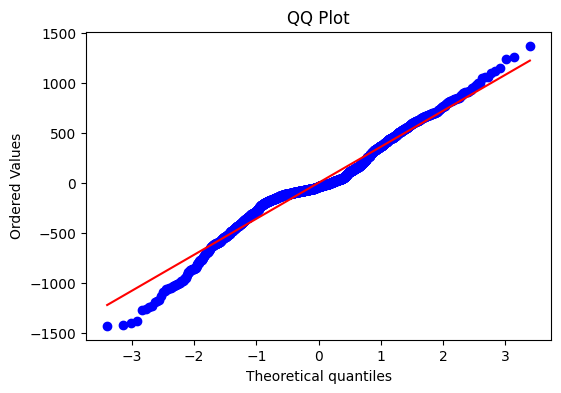


Homoscedasticity Test Results:
Bartlett Test p-value: 0.0005668577145033452
Levene Test p-value: 0.0045581278562486826
Equal variance? No


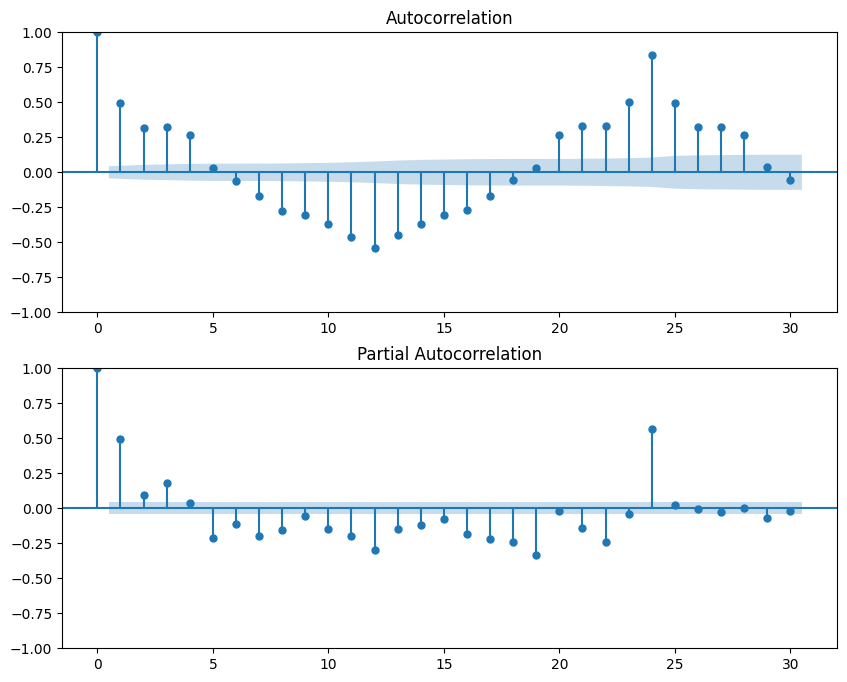

In [19]:
# 클래스 인스턴스 생성
diff1_data = np.diff(train_x_array[0, :,7]) # 첫 번째 건물 전기 사용량, 1차 차분 사용
ts_tester = TimeSeriesTester(diff1_data)

# 클래스의 메서드 호출하여 시계열 데이터에 대한 검정 수행
ts_tester.test_stationarity()
ts_tester.plot_qq_plot()
ts_tester.test_homoscedasticity()
ts_tester.plot_acf_pacf()


In [20]:
model = ARIMA(diff1_data, order = (4,1,5))
fit = model.fit()

preds_diff1 = fit.predict(1, 168, typ ='levels')
len(preds_diff1)

c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


168

### 2차 차분


ADF Test Results:
ADF Statistic: -25.083823415248258
p-value: 0.0
Critical Values: {'1%': -3.433605925774539, '5%': -2.862978297026843, '10%': -2.5675356871295394}
Is data stationary?: Yes


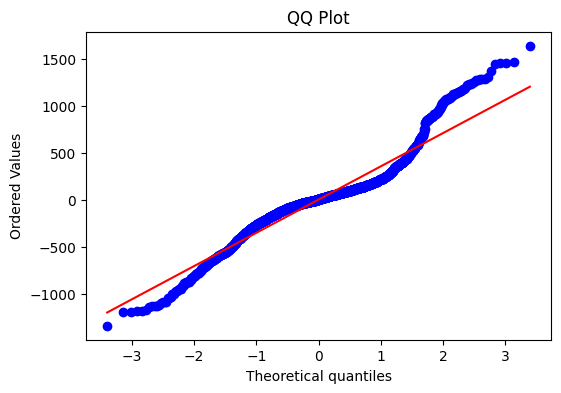


Homoscedasticity Test Results:
Bartlett Test p-value: 7.741265896921677e-18
Levene Test p-value: 2.894488247523542e-08
Equal variance? No


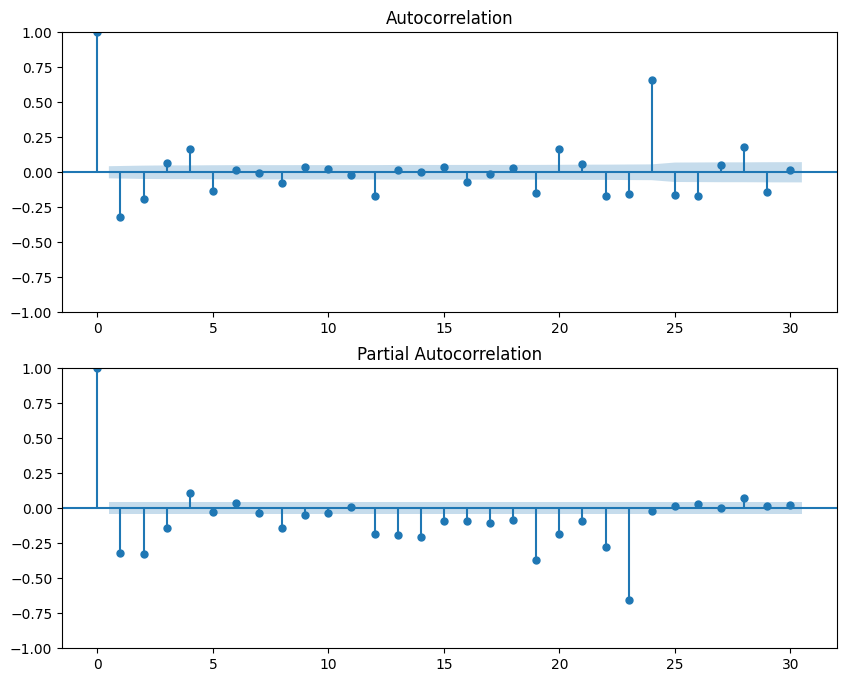

In [21]:
# 클래스 인스턴스 생성
diff2_data = np.diff(np.diff(train_x_array[0, :,7])) # 첫 번째 건물 전기 사용량, 2차 차분 사용
ts_tester = TimeSeriesTester(diff2_data)

# 클래스의 메서드 호출하여 시계열 데이터에 대한 검정 수행
ts_tester.test_stationarity()
ts_tester.plot_qq_plot()
ts_tester.test_homoscedasticity()
ts_tester.plot_acf_pacf()

In [22]:
model = ARIMA(diff2_data, order = (1,2,2))
fit = model.fit()

preds_diff2 = fit.predict(1, 168, typ ='levels')
len(preds_diff2)

c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


168

### log 변환


ADF Test Results:
ADF Statistic: -3.6696797893235233
p-value: 0.004560421814313456
Critical Values: {'1%': -3.43359945413637, '5%': -2.8629754397529616, '10%': -2.5675341657789903}
Is data stationary?: Yes


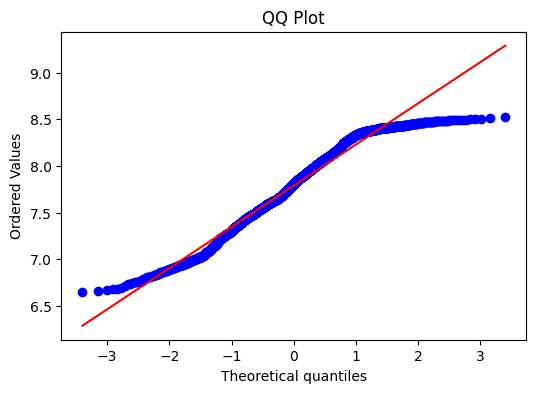


Homoscedasticity Test Results:
Bartlett Test p-value: 6.876703062749456e-17
Levene Test p-value: 3.654734215476084e-17
Equal variance? No


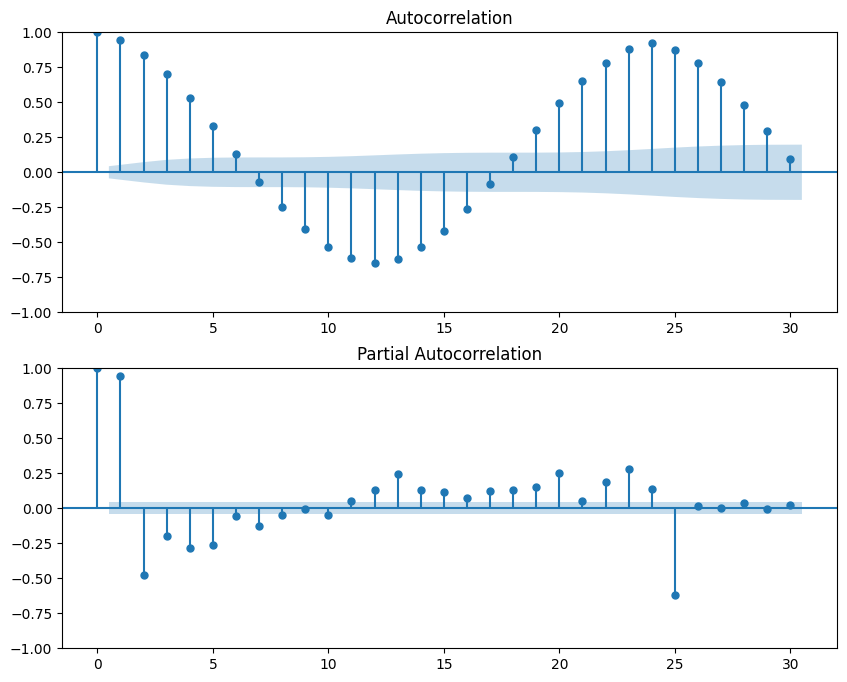

In [23]:
# 클래스 인스턴스 생성
log_only_data = np.log(train_x_array[0, :,7]) # 첫 번째 건물 전기 사용량, 로그 후 차분
ts_tester = TimeSeriesTester(log_only_data)

# 클래스의 메서드 호출하여 시계열 데이터에 대한 검정 수행
ts_tester.test_stationarity()
ts_tester.plot_qq_plot()
ts_tester.test_homoscedasticity()
ts_tester.plot_acf_pacf()

In [24]:
model = ARIMA(log_only_data, order = (5,0,6))
fit = model.fit()

preds_only_log = fit.predict(1, 168, typ ='levels')
len(preds_only_log)

c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


168

In [25]:
np.exp(preds_only_log)

array([1134.50835324, 1103.02450164, 1025.9736514 , 1048.03469231,
       1129.18997582, 1270.91652536, 1594.13180642, 2064.15595258,
       2380.69296239, 2809.15880842, 3264.94496259, 3106.34654146,
       3016.34105083, 2876.67899824, 2695.49908286, 2542.68493487,
       2438.48178623, 2151.14625948, 1892.18323444, 1838.68539037,
       1684.04675879, 1412.82909459, 1191.75980237, 1160.71209206,
       1077.7889288 , 1041.21434074, 1011.33839042, 1020.34442858,
       1086.12975511, 1300.27964319, 1696.68247568, 2101.17365173,
       2970.51444239, 3177.30646563, 3769.98688031, 3664.23977308,
       3601.78848245, 3589.32074545, 3288.48877676, 3133.55592798,
       2936.25088662, 2165.46129777, 2214.95664847, 2080.06075501,
       1887.55133258, 1678.23598702, 1345.65087246, 1270.45672658,
       1214.90951592, 1133.62316624, 1055.22065021, 1102.78884936,
       1140.84159245, 1338.86944192, 1756.11826132, 2184.35791138,
       3065.62003225, 3283.64600329, 3942.11042633, 3975.33956

### log 변환 후 차분


ADF Test Results:
ADF Statistic: -11.880147848271307
p-value: 6.205371269434695e-22
Critical Values: {'1%': -3.43359945413637, '5%': -2.8629754397529616, '10%': -2.5675341657789903}
Is data stationary?: Yes


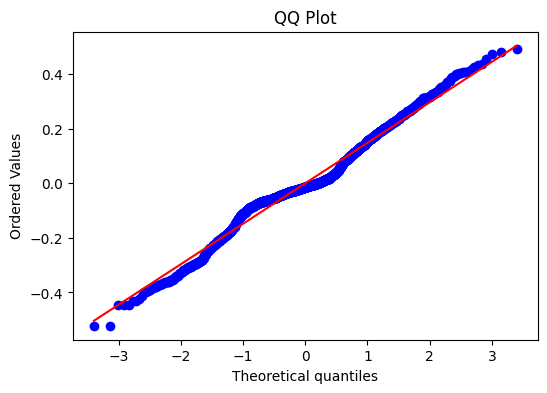


Homoscedasticity Test Results:
Bartlett Test p-value: 0.3578107066561901
Levene Test p-value: 0.6824756037173008
Equal variance? Yes


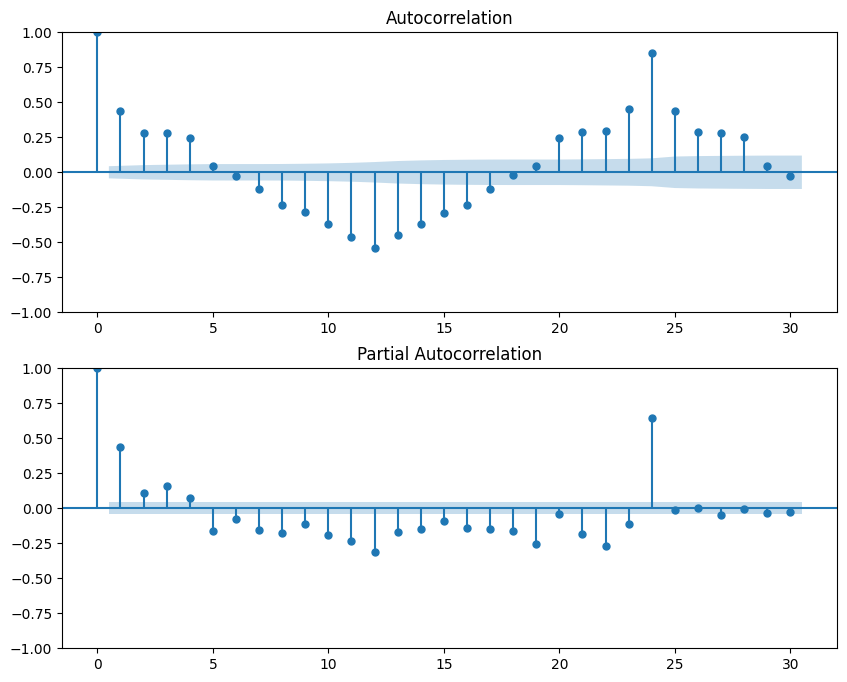

In [26]:
# 클래스 인스턴스 생성
log_data = np.diff(np.log(train_x_array[0, :,7])) # 첫 번째 건물 전기 사용량, 로그 후 차분
ts_tester = TimeSeriesTester(log_data)

# 클래스의 메서드 호출하여 시계열 데이터에 대한 검정 수행
ts_tester.test_stationarity()
ts_tester.plot_qq_plot()
ts_tester.test_homoscedasticity()
ts_tester.plot_acf_pacf()

In [27]:
model = ARIMA(log_data, order = (4,1,4))
fit = model.fit()

preds_log = fit.predict(1, 168, typ ='levels')
len(preds_log)

c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


168

### 역차분 함수 제작(오류 존재 추정)

In [19]:
def inverse_difference(initial_value, differenced_data):
    cumulative_sum = np.cumsum(differenced_data)
    return initial_value + cumulative_sum

In [20]:
np.log(train_x_array[0, :,7])

array([6.9895933 , 6.95402799, 6.88231439, ..., 7.49900262, 7.23504261,
       7.56282669])

In [21]:
np.exp(inverse_difference(np.log(train_x_array[0, :,7])[-1], preds_log)) # 역차분 후 지수함수 사용

array([1858.01015539, 1751.7983506 , 1693.59623082, 1678.57012535,
       1736.58564333, 1943.59266056, 2309.27478519, 2733.93412862,
       3278.12745634, 3896.35503127, 4234.59864839, 4468.45722045,
       4556.93808313, 4502.75782648, 4421.18455424, 4339.62255343,
       4102.45917015, 3740.2379043 , 3500.26253143, 3204.09789751,
       2799.4340439 , 2419.76009344, 2158.19220227, 1911.86798459,
       1760.11338175, 1655.4674441 , 1577.84483382, 1566.92972323,
       1668.9737635 , 1942.16666314, 2331.19298594, 3045.4677895 ,
       3679.5088148 , 4471.20971395, 4986.14680787, 5287.99443696,
       5602.89918128, 5558.4634221 , 5606.49708626, 5482.38020308,
       4747.99440729, 4508.60724609, 4097.40355561, 3745.19399121,
       3427.89904159, 2868.56482043, 2549.64400175, 2236.10847609,
       2008.09289687, 1863.09679225, 1749.00533734, 1726.61952273,
       1809.04174912, 2070.73072682, 2501.77576539, 3222.98463136,
       3865.36364193, 4763.28856618, 5342.81639585, 5615.41562

### 로그&차분 후 예측

In [22]:
valid_pred_array=np.zeros([100, 168])
for idx in range(train_x_array.shape[0]):
    try:
        x_series=np.diff(np.log(train_x_array[idx, :,7]))
        model=ARIMA(x_series, order=(4, 1, 4))
        fit=model.fit()
        preds=fit.predict(1, 168, typ='levels')
        valid_pred_array[idx, :]=np.exp(inverse_difference(np.log(train_x_array[idx, :,7])[-1], preds))
    
    except:
        print(idx, "샘플은 수렴하지 않습니다.")

c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-s

94 샘플은 수렴하지 않습니다.


c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [23]:
valid_pred_array.shape

(100, 168)

In [24]:
submission = pd.read_csv('sample_submission.csv')
submission

,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
16795,100_20220831 19,0
16796,100_20220831 20,0
16797,100_20220831 21,0
16798,100_20220831 22,0


In [25]:
submission['answer']=valid_pred_array.reshape([-1,1])
submission

,num_date_time,answer
0,1_20220825 00,1858.010155
1,1_20220825 01,1751.798351
2,1_20220825 02,1693.596231
3,1_20220825 03,1678.570125
4,1_20220825 04,1736.585643
...,...,...
16795,100_20220831 19,1121.730655
16796,100_20220831 20,1063.637029
16797,100_20220831 21,908.144055
16798,100_20220831 22,794.214836


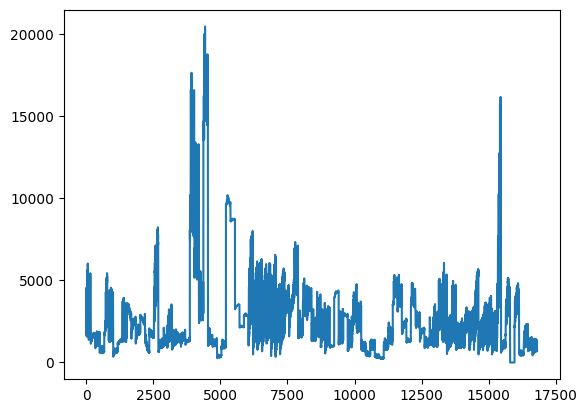

In [26]:
plt.plot(submission['answer'])

In [27]:
submission.to_csv('arima_log_diff.csv', index=False)

### 로그만 예측

In [28]:
range(train_x_array.shape[0])

range(0, 100)

In [29]:
valid_pred_array=np.zeros([100, 168])
for idx in range(train_x_array.shape[0]):
    try:
        try:
            x_series=np.log(train_x_array[idx, :,7])
            model=ARIMA(x_series, order=(5, 1, 6))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=np.exp(preds)
        except:
            x_series=np.log(train_x_array[idx, :,7])
            model=ARIMA(x_series, order=(5, 0, 6))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=np.exp(preds)
        
    except:
        print(idx, "샘플은 수렴하지 않습니다.")

c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

94 샘플은 수렴하지 않습니다.


c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liked\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [30]:
valid_pred_array.shape

(100, 168)

In [36]:
valid_pred_array

array([[1085.28008204, 1030.07737977,  942.52310231, ..., 1551.6040386 ,
        1270.16716006, 1127.01681558],
       [1170.35998689, 1148.03926915, 1117.16419517, ..., 1238.53449731,
         886.19365081, 1143.79265013],
       [ 926.28006465,  864.58746503,  881.26669615, ..., 1402.0726485 ,
         818.63317954,  892.5041321 ],
       ...,
       [ 533.52003851,  509.46810186,  505.20681346, ...,  885.6407474 ,
         413.8917655 ,  359.64839102],
       [ 642.96005702,  574.83817725,  568.78725675, ...,  877.55610504,
         703.21556426,  636.23445123],
       [ 372.00003317,  311.55167051,  313.97998249, ...,  578.08810238,
         421.44235769,  360.8851289 ]])

In [39]:
import numpy as np

# 생성된 NumPy 배열
generated_array = np.array([1160.402197, 1082.85841, 1084.185108, 1050.741176, 1080.22912, 1071.575397, 1446.69854, 2433.005445, 2212.821063, 2284.046639, 2317.926448, 2265.194851, 2235.255476, 2516.680753, 2475.168909, 2395.489045, 2379.848451, 2325.940038, 2117.28319, 2117.775429, 2086.14775, 1757.936397, 1053.659382, 1239.752375, 1237.548062, 1222.131847, 1345.693361, 1252.237415, 1274.506148, 1443.112921, 1440.215233, 1731.736082, 2377.833323, 2249.380497, 2296.676184, 2333.569796, 2274.38621, 2420.812779, 2597.657767, 2382.399108, 2323.065974, 2375.079472, 2209.498667, 2181.202346, 2161.662576, 1318.903748, 1231.693032, 1089.055554, 1077.053576, 1065.274464, 1130.629198, 1908.834368, 1764.933844, 1783.011616, 2038.274069, 2196.798479, 2423.907368, 2625.578947, 2614.29486, 2557.160407, 2558.899207, 2603.98601, 2767.526597, 3043.948246, 2816.911355, 2919.981921, 2421.528851, 2173.713758, 2276.31855, 1994.235202, 1827.642711, 1776.502623, 1739.62468, 1746.68624, 1336.871989, 1192.964145, 1233.793052, 1507.067677, 2209.41618, 2208.8852, 2252.419612, 2373.07489, 2439.772718, 2510.133286, 2687.338973, 3027.758422, 3061.364607, 3004.462765, 2859.005668, 3059.595949, 2904.535171, 2930.074071, 2713.300431, 2118.334765, 1841.652068, 1725.411186, 1512.72656, 1484.539997, 1574.403856, 1535.851662, 1556.997446, 1620.028554, 1911.891552, 2347.096289, 2306.803086, 2484.837638, 2544.008343, 2409.989014, 2532.590845, 2952.050901, 2438.236247, 2483.478179, 2340.69643, 2284.699355, 2356.840453, 2247.913121, 2117.196246, 1808.42578, 1803.87705, 1641.992205, 1472.818407, 1277.031638, 1206.779803, 1249.437628, 1356.570384, 1375.220238, 2036.492768, 2236.66698, 2063.213745, 2165.752532, 2206.311049, 2030.11775, 2100.24386, 2197.223614, 2155.517358, 2054.192906, 2048.499833, 2099.145421, 2001.420572, 1876.363036, 1847.561746, 1271.755067, 1053.829147, 1101.096445, 1169.304671, 1176.771565, 1218.208049, 1160.700002, 1180.919441, 1213.689572, 1453.585628, 1832.649548, 2198.75478, 2028.985594, 2246.484843, 2188.831318, 2094.417195, 2201.791028, 2061.067114, 2025.255816, 1991.815294, 2018.541379, 1912.607534, 1706.416245, 1333.576507, 1358.806034, 1252.705751, 1218.935348])
len(generated_array)

168

In [41]:
valid_pred_array[94][:] = generated_array
valid_pred_array[94]

array([1160.402197, 1082.85841 , 1084.185108, 1050.741176, 1080.22912 ,
       1071.575397, 1446.69854 , 2433.005445, 2212.821063, 2284.046639,
       2317.926448, 2265.194851, 2235.255476, 2516.680753, 2475.168909,
       2395.489045, 2379.848451, 2325.940038, 2117.28319 , 2117.775429,
       2086.14775 , 1757.936397, 1053.659382, 1239.752375, 1237.548062,
       1222.131847, 1345.693361, 1252.237415, 1274.506148, 1443.112921,
       1440.215233, 1731.736082, 2377.833323, 2249.380497, 2296.676184,
       2333.569796, 2274.38621 , 2420.812779, 2597.657767, 2382.399108,
       2323.065974, 2375.079472, 2209.498667, 2181.202346, 2161.662576,
       1318.903748, 1231.693032, 1089.055554, 1077.053576, 1065.274464,
       1130.629198, 1908.834368, 1764.933844, 1783.011616, 2038.274069,
       2196.798479, 2423.907368, 2625.578947, 2614.29486 , 2557.160407,
       2558.899207, 2603.98601 , 2767.526597, 3043.948246, 2816.911355,
       2919.981921, 2421.528851, 2173.713758, 2276.31855 , 1994.

In [43]:
submission = pd.read_csv('data/sample_submission.csv')
submission

,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
16795,100_20220831 19,0
16796,100_20220831 20,0
16797,100_20220831 21,0
16798,100_20220831 22,0


In [44]:
submission['answer']=valid_pred_array.reshape([-1,1])
submission

,num_date_time,answer
0,1_20220825 00,1085.280082
1,1_20220825 01,1030.077380
2,1_20220825 02,942.523102
3,1_20220825 03,937.805643
4,1_20220825 04,988.939488
...,...,...
16795,100_20220831 19,716.489968
16796,100_20220831 20,650.304312
16797,100_20220831 21,578.088102
16798,100_20220831 22,421.442358


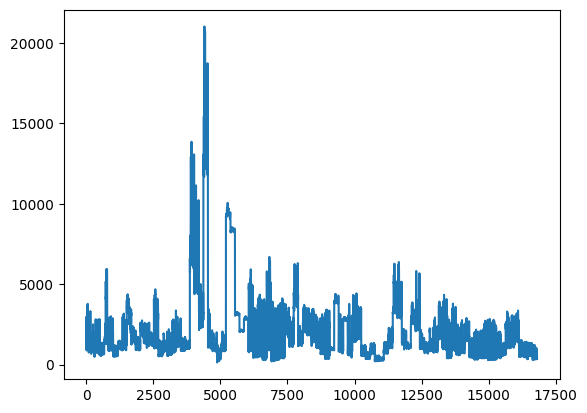

In [45]:
plt.plot(submission['answer'])

In [46]:
submission.to_csv('submit/arima_log.csv', index=False)